# Cell-Path Distance Matrix
This notebook is used to compute the cell-path distance matrix for the cell-specific anelastic attenuation

## Load required libraries

In [1]:
#load libraries
import os
import sys
import pathlib
import numpy as np
import pandas as pd
from scipy import sparse
#geographic libraries
import pyproj
#jupyter
from IPython.display import clear_output
#user libraries
sys.path.insert(0,'../Python_lib/ground_motions')
sys.path.insert(0,'../Python_lib/plotting')
import pylib_cell_dist as pylib_cells
import pylib_contour_plots as pylib_cplt

## User Input
Define flatfile filename and output directory

In [2]:
#ground-motion flatifle name and directory
name_flatfile = 'CatalogNGAWest3CALite'
dir_flatfile  = '../../Data/Verification/preprocessing/flatfiles/merged/'

#flag for UTM coordinates
flagUTM = True

#cell grid limits (UTM coordinates in km)
grid_lims_x = [-200,    800]
grid_lims_y = [3450,    4725]
grid_lims_z = [-50,     0]

#cell size
cell_size = [25, 25, 50]

#output files
dir_out = '../../Data/Data_Preperation/cell_distances/'

## Load Files

In [3]:
df_flatfile = pd.read_csv(dir_flatfile + name_flatfile + '.csv')
n_rec = len(df_flatfile)
print('Number of records:', n_rec)

Number of records: 157438


## Preprocessing 

In [4]:
#define projection system 
assert(len(np.unique(df_flatfile.UTMzone))==1),'Error. Multiple UTM zones.'
utm_zone = df_flatfile.UTMzone[0]
utmProj = pyproj.Proj("+proj=utm +zone="+utm_zone+", +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

#create matrix with source and station locations
data4celldist = df_flatfile.loc[:,['eqX','eqY','eqZ','staX','staY']].values 
#add column for elevation for stations, assume 0
data4celldist = np.hstack([data4celldist,np.zeros([n_rec,1])])

#check that all coordinates are inside the grid
assert(np.logical_and(data4celldist[:,[0,3]].min()>=grid_lims_x[0], 
                      data4celldist[:,[0,3]].max()<=grid_lims_x[1])),\
                      'Error. Events or Sations outside grid cell in x direction.'
assert(np.logical_and(data4celldist[:,[1,4]].min()>=grid_lims_y[0], 
                      data4celldist[:,[1,4]].max()<=grid_lims_y[1])),\
                      'Error. Events or Sations outside grid cell in y direction.'
assert(np.logical_and(data4celldist[:,[2,5]].min()>=grid_lims_z[0], 
                      data4celldist[:,[2,5]].max()<=grid_lims_z[1])),\
                      'Error. Events or Sations outside grid cell in z direction.'

### Cell Vertices Coordinates

In [5]:
#cell schematic
#    (7)-----(8)  (surface, top face)
#   / |     / |
# (5)-----(6) |
#  |  |    |  |
#  | (3)---|-(4)  (bottom face)
#  |/      |/
# (1)-----(2)

#grid spacing
grid_x = np.arange(grid_lims_x[0], grid_lims_x[1]+0.1, cell_size[0])
grid_y = np.arange(grid_lims_y[0], grid_lims_y[1]+0.1, cell_size[1])
grid_z = np.arange(grid_lims_z[0], grid_lims_z[1]+0.1, cell_size[2])

#create cells
cells = []
for j1 in range(len(grid_x)-1):
    for  j2 in range(len(grid_y)-1):
        for j3 in range(len(grid_z)-1):
            #cell corners (bottom-face)
            cell_c1 = [grid_x[j1],   grid_y[j2],   grid_z[j3]]
            cell_c2 = [grid_x[j1+1], grid_y[j2],   grid_z[j3]]
            cell_c3 = [grid_x[j1],   grid_y[j2+1], grid_z[j3]]
            cell_c4 = [grid_x[j1+1], grid_y[j2+1], grid_z[j3]]
            #cell corners (top-face)
            cell_c5 = [grid_x[j1],   grid_y[j2],   grid_z[j3+1]]
            cell_c6 = [grid_x[j1+1], grid_y[j2],   grid_z[j3+1]]
            cell_c7 = [grid_x[j1],   grid_y[j2+1], grid_z[j3+1]]
            cell_c8 = [grid_x[j1+1], grid_y[j2+1], grid_z[j3+1]]
            #cell center
            cell_cent = np.mean(np.stack([cell_c1,cell_c2,cell_c3,cell_c4,
                                          cell_c5,cell_c6,cell_c7,cell_c8]),axis = 0).tolist()
            #summarize all cell coordinates in a list
            cell_info = cell_c1 + cell_c2 + cell_c3 + cell_c4 + \
                        cell_c5 + cell_c6 + cell_c7 + cell_c8 + cell_cent
            #add cell info
            cells.append(cell_info)
del j1, j2, j3, cell_info
del cell_c1, cell_c2, cell_c3, cell_c4, cell_c5, cell_c6, cell_c7, cell_c8
cells = np.array(cells)
n_cells = len(cells)

#cell info
cell_ids   = np.arange(n_cells)
cell_names = ['c.%i'%(i) for i in cell_ids]
cell_q_names =  ['q1X','q1Y','q1Z','q2X','q2Y','q2Z','q3X','q3Y','q3Z','q4X','q4Y','q4Z',
                 'q5X','q5Y','q5Z','q6X','q6Y','q6Z','q7X','q7Y','q7Z','q8X','q8Y','q8Z',
                 'mptX','mptY','mptZ']

### Cell Info Dataframe

In [6]:
#cell names
df_data1 = pd.DataFrame({'cellid': cell_ids, 'cellname': cell_names})
#cell coordinates
df_data2 = pd.DataFrame(cells, columns = cell_q_names)
df_cellinfo  = pd.merge(df_data1,df_data2,left_index=True,right_index=True)
del df_data1, df_data2
# add cell utm zone
df_cellinfo.loc[:,'UTMzone'] = utm_zone

#cell lat\lon verticies
for q in range(1,9):
    c_X      = ['q%iX'%q,   'q%iY'%q]
    c_latlon = ['q%iLat'%q, 'q%iLon'%q]
    
    df_cellinfo.loc[:,c_latlon]  = np.flip( np.array([utmProj(pt_xy[0]*1e3, pt_xy[1]*1e3, inverse=True) 
                                                      for _, pt_xy in df_cellinfo[c_X].iterrows() ]),   axis=1)
#cell midpoints
c_X      = ['mptX',  'mptY']
c_latlon = ['mptLat','mptLon']
df_cellinfo.loc[:,c_latlon]  = np.flip( np.array([utmProj(pt_xy[0]*1e3, pt_xy[1]*1e3, inverse=True) 
                                                  for _, pt_xy in df_cellinfo[c_X].iterrows() ]),   axis=1)

## Compute Cell-Path Distance Matrix

In [7]:
cells4dist  = cells[:,[0,1,2,21,22,23]] 
distancematrix  = np.zeros([len(data4celldist), len(cells4dist)])
for i in range(len(data4celldist)):
    clear_output(wait=True)
    print('Computing cell distances, record:',i)
    pt1 = data4celldist[i,(0,1,2)]
    pt2 = data4celldist[i,(3,4,5)]
  
    dm = pylib_cells.ComputeDistGridCells(pt1,pt2,cells4dist, flagUTM)
    distancematrix[i] = dm
    
#print Rrup missfits
dist_diff = df_flatfile.Rrup - distancematrix.sum(axis=1)
clear_output(wait=True)
print('Cell distance calculation completed')
print('max R_rup misfit', max(dist_diff.abs()))

#convert cell distances to sparse matrix
distmatrix_sparce = sparse.coo_matrix(distancematrix)

#cell distances data-frame
#gm record info
df_recinfo = df_flatfile[['rsn','eqid','ssn']]

#cell distances
df_celldist = pd.DataFrame(distancematrix, columns = cell_names)
df_celldist = pd.merge(df_recinfo, df_celldist, left_index=True, right_index=True)

#spase cell distances dataframe
df_celldist_sp = pd.DataFrame({'row':  distmatrix_sparce.row+1, 
                               'col':  distmatrix_sparce.col+1, 
                               'data': distmatrix_sparce.data})

Cell distance calculation completed
max R_rup misfit 1.7621459846850485e-12


## Save Data

In [8]:
#create output directory
if not os.path.isdir(dir_out): pathlib.Path(dir_out).mkdir(parents=True, exist_ok=True) 

#save cell info
name_cellinfo = name_flatfile + '_cellinfo'
df_cellinfo.to_csv(dir_out + name_cellinfo + '.csv', index=False)

#save distance metrics
name_celldist = name_flatfile + '_distancematrix'
df_celldist.to_csv(dir_out + name_celldist + '.csv', index=False)

#save distance matrix as sparce
name_celldist = name_flatfile + '_distancematrix_sparce'
df_celldist_sp.to_csv(dir_out + name_celldist + '.csv', index=False)

## Summary Figures

### Figures Options

In [9]:
#plot limits
fig_latlon_win = np.array([[31, -126],[43.5, -113]])
#fig_latlon_win = np.array([[32, -125],[42.5, -114]])

#color limits for number of paths
cmin = 0
cmax = 2000

#flag log scale for number of paths
flag_logscl = True

### Figure Info Summary

In [10]:
#earthquake and station ids
eq_id, eq_idx_inv   = np.unique(df_flatfile['eqid'].values.astype(int), return_index=True)
sta_id, sta_idx_inv = np.unique(df_flatfile['ssn'].values.astype(int),  return_index=True)

#earthquake and station coordinates
eq_latlon   = df_flatfile[['eqLat',  'eqLon']].values[eq_idx_inv,:]
stat_latlon = df_flatfile[['staLat', 'staLon']].values[sta_idx_inv,:]

#cell coordinates
cell_latlon_mpt  = df_cellinfo[['mptLat','mptLon']].values
cell_latlon_edge = df_cellinfo[['q5Lat','q5Lon','q6Lat','q6Lon','q8Lat','q8Lon', 
                                'q7Lat','q7Lon','q5Lat','q5Lon']].values

#number of paths per cell
cell_n_paths = (distancematrix > 0).sum(axis=0)

### Plotting

/mnt/halcloud_nfs/glavrent/Research/Nonerg_GMM_methodology/Analyses/Data_Preparation/../Python_lib/plotting/pylib_contour_plots.py:661: RuntimeWarning: divide by zero encountered in log
  data_cell = np.log(cell_latlondata[:,2])


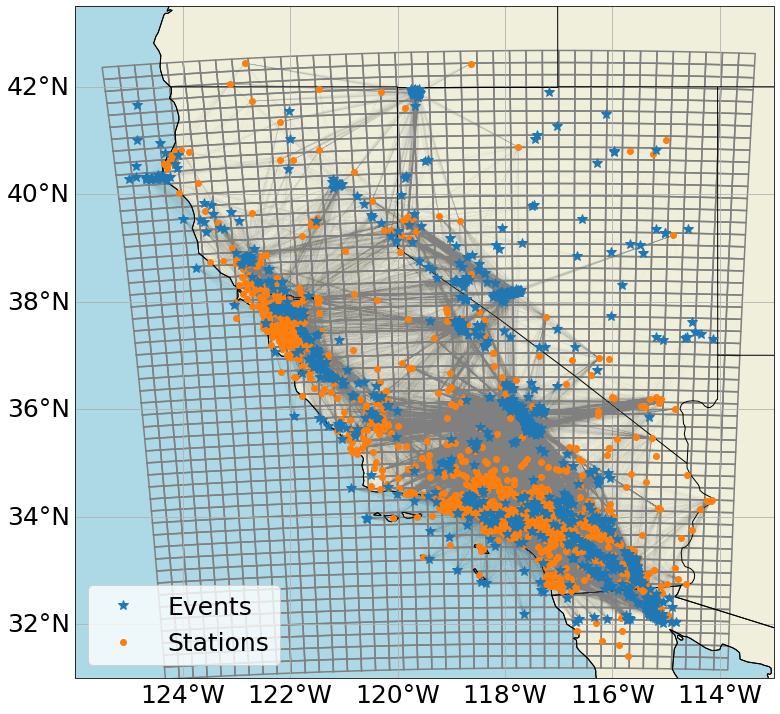

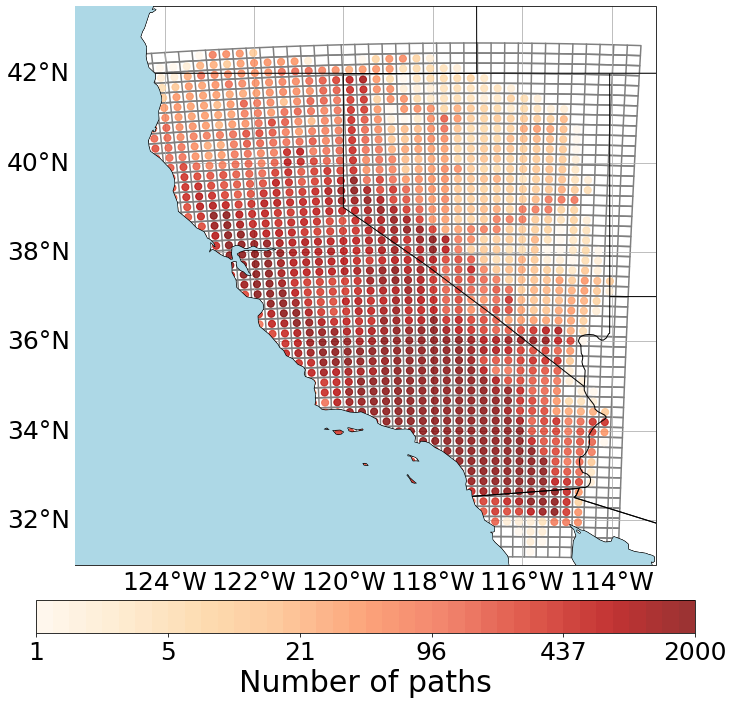

In [11]:
# Plot cell paths
# ---   ---   ---   ---
fname_fig = 'cA_paths'
fig, ax, data_crs, gl = pylib_cplt.PlotMap()
#plot earthquake and station locations
ax.plot(eq_latlon[:,1],   eq_latlon[:,0],   '*', transform=data_crs, markersize=10, zorder=13, label='Events')
ax.plot(stat_latlon[:,1], stat_latlon[:,0], 'o', transform=data_crs, markersize=6,  zorder=12, label='Stations')
#plot earthquake-station paths
for rec in df_flatfile[['eqLat','eqLon','staLat','staLon']].iterrows():
    ax.plot(rec[1][['eqLon','staLon']], rec[1][['eqLat','staLat']], 
            transform = data_crs, color = 'gray', linewidth=0.05, zorder=10, alpha=0.2)
#plot cells
for ce_xy in cell_latlon_edge:
    ax.plot(ce_xy[[1,3,5,7,9]],ce_xy[[0,2,4,6,8]], color='gray', transform=data_crs)
#figure limits
ax.set_xlim( fig_latlon_win[:,1] )
ax.set_ylim( fig_latlon_win[:,0] )
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.top_labels   = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
#add legend
ax.legend(fontsize=25, loc='lower left')
#apply tight layout
#fig.show()
fig.tight_layout()
fig.savefig( dir_out + fname_fig + '.png')

# Plot cell paths
# ---   ---   ---   ---
fname_fig = 'cA_num_paths'
cbar_label = 'Number of paths'
data2plot = np.vstack([cell_latlon_mpt.T, cell_n_paths]).T
#log scale options
if flag_logscl:
    cmin = np.log(1)
    cmax = np.log(cmax)
#create figure
fig, ax, cbar, data_crs, gl = pylib_cplt.PlotCellsCAMap(data2plot, cmin=cmin,  cmax=cmax, 
                                                        log_cbar=flag_logscl,
                                                        frmt_clb='%.0f',  cmap='OrRd')
#plot cells
for ce_xy in cell_latlon_edge:
    ax.plot(ce_xy[[1,3,5,7]],ce_xy[[0,2,4,6]], color='gray', transform=data_crs)
#figure limits
ax.set_xlim( fig_latlon_win[:,1] )
ax.set_ylim( fig_latlon_win[:,0] )
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.top_labels   = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
#update colorbar 
cbar.set_label(cbar_label, size=30)
cbar.ax.tick_params(labelsize=25)
#apply tight layout
#fig.show()
fig.tight_layout()
fig.savefig( dir_out + fname_fig + '.png')